# Packages

In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Loading

In [33]:
# Loading the data
salary_threshold = pd.read_csv("Agent Salary and Eligibility Threshold.csv")
staffing = pd.read_csv("Existing Agent Staffing.csv")
sign_ups = pd.read_csv("Advertiser Sign-ups.csv")

# Merge country-specific staffing, agents salary and threshold info to one dataframe
agents = pd.merge(salary_threshold, staffing, on="Country", how="left")

# Add threshold to sign-ups to determine eligibility
sign_ups = sign_ups.merge(salary_threshold[["Country", "Advertiser_Eligibility_Threshold_USD"]], on="Country", how="left")

# Add year, month, day and eligibility columns to sign-ups
sign_ups['Sign_Up_Date'] = pd.to_datetime(sign_ups['Sign_Up_Date'])
sign_ups['Sign_Up_Year'] = sign_ups['Sign_Up_Date'].dt.year
sign_ups['Sign_Up_Month'] = sign_ups['Sign_Up_Date'].dt.month
sign_ups['Sign_Up_Day'] = sign_ups['Sign_Up_Date'].dt.day
sign_ups["Eligible"] = sign_ups["Advertiser_Eligibility_Threshold_USD"] < sign_ups["Projected_Annual_Budget"]
sign_ups_eligible = sign_ups[sign_ups["Eligible"]]

# Split sign-ups into 2023 and 2024
sign_ups2023 = sign_ups[sign_ups['Sign_Up_Year'] == 2023]
sign_ups2024 = sign_ups[sign_ups['Sign_Up_Year'] == 2024]

# Split sign-ups into eligible and ineligible for both years
sign_ups2023_eligible = sign_ups2023[sign_ups2023["Eligible"]]
sign_ups2024_eligible = sign_ups2024[sign_ups2024["Eligible"]]
sign_ups2023_ineligible = sign_ups2023[~sign_ups2023["Eligible"]]
sign_ups2024_ineligible = sign_ups2024[~sign_ups2024["Eligible"]]

In [35]:
print(f"Number of sign-ups in 2023: {sign_ups2023.shape[0]}")
print(f"Elegibile sign-ups in 2023: {sign_ups2023_eligible.shape[0]}")
print(f"Ineligible sign-ups in 2023: {sign_ups2023_ineligible.shape[0]}")

Number of sign-ups in 2023: 252019
Elegibile sign-ups in 2023: 106976
Ineligible sign-ups in 2023: 145043


In [37]:
print(f"Number of sign-ups in 2024: {sign_ups2024.shape[0]}")
print(f"Elegibile sign-ups in 2024: {sign_ups2024_eligible.shape[0]}")
print(f"Ineligible sign-ups in 2024: {sign_ups2024_ineligible.shape[0]}")

Number of sign-ups in 2024: 247625
Elegibile sign-ups in 2024: 105358
Ineligible sign-ups in 2024: 142267


# Sign Ups with Moving Averages by Country

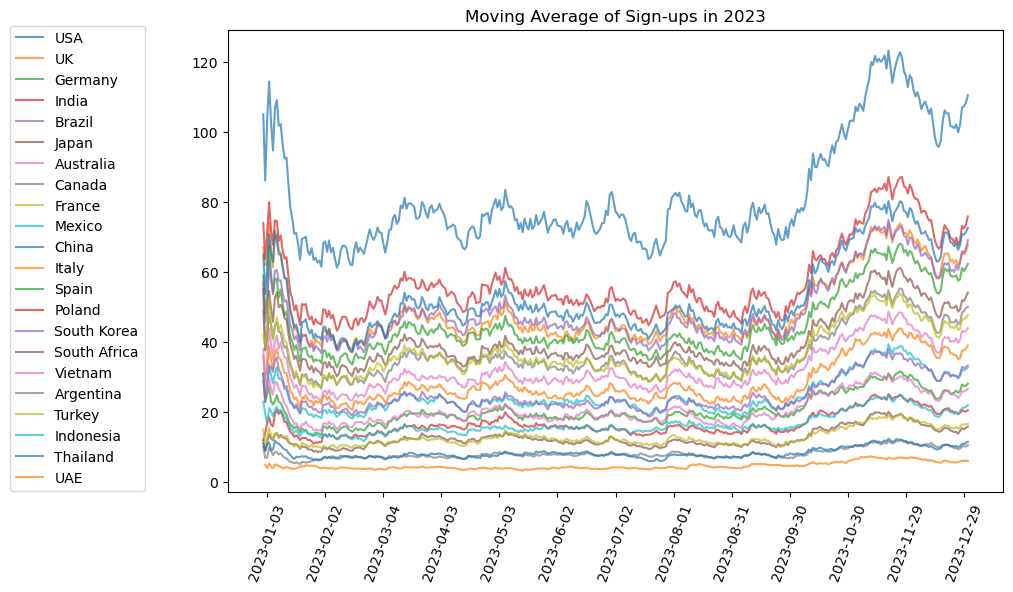

In [40]:
def countSignUps(df, country):
    ''' 
    Group by country and count the number of sign-ups
    '''

    df_grouped = pd.DataFrame(df
                            .loc[df["Country"] == country]
                            .groupby("Sign_Up_Date")
                            .count()["Advertiser_ID"])
    # df_grouped["Date"] = pd.to_datetime(year + '-' + df_grouped['Sign_Up_Month'].astype(str) + 
    #                '-' + df_grouped['Sign_Up_Day'].astype(str), format='%Y-%m-%d')
    df_grouped.index = df_grouped.index.rename("Date")
    df_grouped.columns = ["Sign_Ups"]
    df_grouped["Country"] = country
    return df_grouped

def visSignUps(sign_ups):
    ''' 
    Visualize the number of sign_ups, where sign_ups is a dataframe with a Date index and a Sign_Ups column 
    '''
    
    # Exponential Moving Average
    ewm = sign_ups[["Sign_Ups"]]
    ewm = ewm.ewm(times = ewm.index, halflife='15 days').mean()

    # Add Sign-ups, EMA and SMA
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sign_ups.index, sign_ups['Sign_Ups'], alpha = 0.3, label = "Sign-ups")
    ax.plot(ewm['Sign_Ups'], label = "Exponential Weighted Moving Average", color = "red", alpha = 0.7)
    ax.plot(sign_ups['Sign_Ups'].rolling(window=30).mean(), label = "30-day Moving Average", color = "green")

    # x ticks formatting - every 30 days
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.xticks(rotation=70)

    plt.title(f"Sign-ups in {sign_ups['Country'].iloc[0]}")
    plt.legend()
    plt.show()

def visSignUpsAll(sign_ups, year):
    ''' 
    Visualize the number of sign_ups for all countries
    '''

    fig, ax = plt.subplots(figsize=(10, 6))

    for country in sign_ups["Country"].unique():
        sign_ups_country_grouped = countSignUps(sign_ups, country)
        ewm = sign_ups_country_grouped[["Sign_Ups"]]
        ewm = ewm.ewm(times = ewm.index, halflife='15 days').mean()
        ax.plot(ewm['Sign_Ups'], label = f"{country}", alpha = 0.7)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    fig.legend(bbox_to_anchor=(-0.1, 0.1), loc='lower left', ncol=1)
    plt.xticks(rotation=70)

    plt.title(f"Moving Average of Sign-ups in {year}")
    plt.show()

sign_ups2023_USA_grouped = countSignUps(sign_ups2023, 'USA')
sign_ups2024_USA_grouped = countSignUps(sign_ups2024, 'USA')
sign_ups_USA_grouped = pd.concat([sign_ups2023_USA_grouped, sign_ups2024_USA_grouped])

#visSignUps(sign_ups2023_USA_grouped)

visSignUpsAll(sign_ups2023, 2023)

# Analysis

2 main datasets: 

"agents", showing country-specific information about 
* Annual salary
* Eligibility threshold for advertisers
* Count of existing agents on 1 Jan 2025

"sign-ups":
* Advertiser ID
* Country
* Sign-up Date
* Projected Budget 



In [44]:
agents

,Country,Annual_Agent_Salary_USD,Advertiser_Eligibility_Threshold_USD,Existing_Agent_Count
0,USA,77721,35000,652
1,UK,51650,27000,589
2,Germany,51328,26000,602
3,India,14118,13000,428
4,Brazil,27950,29000,189
5,Japan,49545,17000,297
6,Australia,43505,16000,450
7,Canada,61060,20000,228
8,France,65384,22000,489
9,Mexico,19789,8000,442


In [46]:
sign_ups2023_eligible

,Advertiser_ID,Country,Sign_Up_Date,Projected_Annual_Budget,Advertiser_Eligibility_Threshold_USD,Sign_Up_Year,Sign_Up_Month,Sign_Up_Day,Eligible
0,A000001,USA,2023-01-01,84376,35000,2023,1,1,True
1,A000002,USA,2023-01-01,57297,35000,2023,1,1,True
3,A000004,USA,2023-01-01,154506,35000,2023,1,1,True
7,A000008,USA,2023-01-01,104967,35000,2023,1,1,True
8,A000009,USA,2023-01-01,44165,35000,2023,1,1,True
...,...,...,...,...,...,...,...,...,...
252009,A252010,Thailand,2023-12-31,7998,4000,2023,12,31,True
252011,A252012,Thailand,2023-12-31,7024,4000,2023,12,31,True
252016,A252017,UAE,2023-12-31,3645,1000,2023,12,31,True
252017,A252018,UAE,2023-12-31,1376,1000,2023,12,31,True


# Dummy Strategy

$H_t, F_t$ - number of agents hired/fired at day t

**Strategy**:

Calculate $D_{60}$ - average predicted demand for the next 60 days 

Threshold $Th$ - average demand for the whole time period

* Each day t:

* If $D_{60} > Th$: $H_t = 11, F_t = 0$

* Else: $H_t = 0, F_t = 3$

* Assign all available agents to best advertisers

* Assume that all sign-ups at day $t$ have the same averaged budget

In [50]:
sign_ups2023_USA_grouped = countSignUps(sign_ups2023, 'USA')
sign_ups2024_USA_grouped = countSignUps(sign_ups2024, 'USA')
sign_ups_USA_grouped = pd.concat([sign_ups2023_USA_grouped, sign_ups2024_USA_grouped])

df_grouped = pd.DataFrame(sign_ups_eligible
                            .loc[sign_ups_eligible["Country"] == "USA"]
                            .groupby("Sign_Up_Date")["Projected_Annual_Budget"]
                            .mean())

budget_demand = pd.concat([sign_ups_USA_grouped, df_grouped], axis=1)
budget_demand = budget_demand[["Sign_Ups", "Projected_Annual_Budget"]]
budget_demand.columns = ["Demand", "Budget"]
budget_demand.head(5)

,Demand,Budget
2023-01-01,105,86415.490566
2023-01-02,68,84614.000000
2023-01-03,136,80838.070175
2023-01-04,144,84958.636364
2023-01-05,62,86109.344828


In [25]:
threshold = budget_demand["Demand"].mean()

# Agents pool
free_agents = agents.loc[agents["Country"] == "USA"].loc[:,"Existing_Agent_Count"][0]

salary = agents.iloc[0,1]

# Advertisers pool

max_profit = 0
H_best, F_best = 0, 0

for H in range(1, 20):
    for F in range(1, 20):
        print(H,F)

        agents_pool = np.array([[0 for i in range(10)] for _ in range(free_agents)])
        adv_id = 1
        advertiser_pool = []

        start_index = budget_demand.index.get_loc("2023-01-01")
        current_date = budget_demand.index[start_index]

        Costs = 0
        Rev = 0

        uplift = 0.135

        for day in range(365):

            # Add new sign-ups to the pool
            todays_demand = budget_demand.loc[current_date]["Demand"]
            todays_budget = budget_demand.loc[current_date]["Budget"]
            for _ in range(int(todays_demand)):
                advertiser_pool.append([todays_budget, 0, adv_id])
                adv_id += 1

            advertiser_pool.sort(key = lambda x: x[0], reverse = True)
            
            # Demand info about next 60 days
            demand_next60 = budget_demand.loc[current_date:current_date + pd.Timedelta(days = 60)]["Demand"].mean()
            budget_next60 = budget_demand.loc[current_date:current_date + pd.Timedelta(days = 60)]["Budget"].mean()


            # If mean budget over next 60 days is higher than threshold, hire new agents
            if demand_next60 > threshold:
                # Hire H agents
                for _ in range(H):
                    agents_pool = np.append(agents_pool, np.repeat(30,10)[np.newaxis, :], axis=0)

            #elif demand_next60 < 0.9 * threshold:
            else:
                # Try to fire F agents
                count_fired = 0
                idx_fired = []
                for i in range(agents_pool.shape[0]):
                    if np.sum(agents_pool[i] > 30) == 0:
                        Costs += 30 * salary/365
                        Costs += 0.4 * salary
                        idx_fired.append(i)
                        count_fired += 1
                        if count_fired == F:
                            break
                agents_pool = np.delete(agents_pool, idx_fired, axis=0)
                
            # Update costs
            Costs += agents_pool.shape[0] * salary/365

            # Assignment 
            ids_remove = []
            zero_indices = np.argwhere(agents_pool == 0)
            curr_pos = 0
            if zero_indices.shape[0] > 0:
                for i in range(len(advertiser_pool)):
                    x, y = zero_indices[curr_pos]
                    curr_pos += 1
                    agents_pool[x][y] = 60

                    Rev += advertiser_pool[i][0] * uplift
                    ids_remove.append(advertiser_pool[i][2])
                    if curr_pos >= zero_indices.shape[0]:
                        break


            # Update agents pool
            for j in range(agents_pool.shape[0]):
                for spot in range(10):
                    if agents_pool[j][spot] > 0:
                        agents_pool[j][spot] -= 1

            advertiser_pool = [x for x in advertiser_pool if x[2] not in ids_remove]

            # Update advertisers count
            for i in range(len(advertiser_pool)):
                advertiser_pool[i][1] += 1
            
            advertiser_pool = [x for x in advertiser_pool if x[1] < 60]

            current_date += pd.Timedelta(days = 1)

            #print(f"Costs: {Costs}, Revenue: {Rev}")
                        


        Profit = Rev - Costs
        if Profit > max_profit:
            max_profit = Profit
            H_best = H
            F_best = F
        max_profit = max(max_profit, Profit)

print(max_profit, H_best, F_best)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
11 17
11 18
11 19
12 1
12 2
12 3
1

## H = 11, F = 3 - Dummy Strategy 

Profit: 208113006.39958894


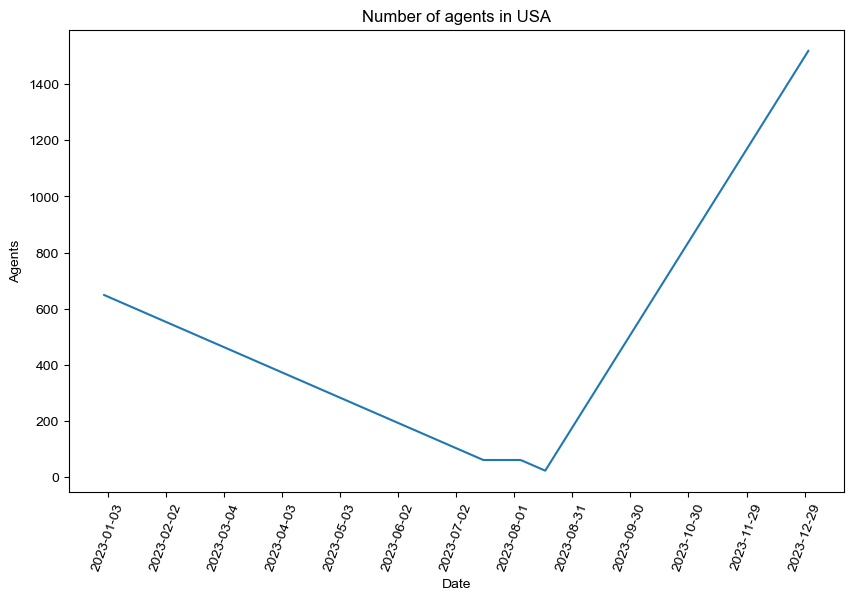

In [57]:
import seaborn as sns

agents_pool = np.array([[0 for i in range(10)] for _ in range(free_agents)])
adv_id = 1
advertiser_pool = []

start_index = budget_demand.index.get_loc("2023-01-01")
current_date = budget_demand.index[start_index]

Costs = 0
Rev = 0

uplift = 0.135

agent = []

for day in range(365):

    # Add new sign-ups to the pool
    todays_demand = budget_demand.loc[current_date]["Demand"]
    todays_budget = budget_demand.loc[current_date]["Budget"]
    for _ in range(int(todays_demand)):
        advertiser_pool.append([todays_budget, 0, adv_id])
        adv_id += 1

    advertiser_pool.sort(key = lambda x: x[0], reverse = True)
    
    # Demand info about next 60 days
    demand_next60 = budget_demand.loc[current_date:current_date + pd.Timedelta(days = 60)]["Demand"].mean()
    budget_next60 = budget_demand.loc[current_date:current_date + pd.Timedelta(days = 60)]["Budget"].mean()


    # If mean budget over next 60 days is higher than threshold, hire new agents
    if demand_next60 > threshold:
        # Hire H agents
        H = 11
        for _ in range(H):
            agents_pool = np.append(agents_pool, np.repeat(30,10)[np.newaxis, :], axis=0)

    #elif demand_next60 < 0.9 * threshold:
    else:
        # Try to fire F agents
        F = 3
        count_fired = 0
        idx_fired = []
        for i in range(agents_pool.shape[0]):
            if np.sum(agents_pool[i] > 30) == 0:
                Costs += 30 * salary/365
                Costs += 0.4 * salary
                idx_fired.append(i)
                count_fired += 1
                if count_fired == F:
                    break
        agents_pool = np.delete(agents_pool, idx_fired, axis=0)
        
    # Update costs
    Costs += agents_pool.shape[0] * salary/365

    # Assignment 
    ids_remove = []
    zero_indices = np.argwhere(agents_pool == 0)
    curr_pos = 0
    if zero_indices.shape[0] > 0:
        for i in range(len(advertiser_pool)):
            x, y = zero_indices[curr_pos]
            curr_pos += 1
            agents_pool[x][y] = 60

            Rev += advertiser_pool[i][0] * uplift
            ids_remove.append(advertiser_pool[i][2])
            if curr_pos >= zero_indices.shape[0]:
                break


    # Update agents pool
    for j in range(agents_pool.shape[0]):
        for spot in range(10):
            if agents_pool[j][spot] > 0:
                agents_pool[j][spot] -= 1

    advertiser_pool = [x for x in advertiser_pool if x[2] not in ids_remove]

    # Update advertisers count
    for i in range(len(advertiser_pool)):
        advertiser_pool[i][1] += 1
    
    advertiser_pool = [x for x in advertiser_pool if x[1] < 60]

    current_date += pd.Timedelta(days = 1)
    
    agent.append(agents_pool.shape[0])
                

Profit = Rev - Costs

print(f"Profit: {Profit}")

agent = np.array(agent)

dates = budget_demand.index[:agent.shape[0]]

fig, ax = plt.subplots(figsize=(10, 6))

dates_agents = pd.DataFrame({"Date": dates, "Agents": agent})

sns.set_theme()
sns.lineplot(dates_agents, x = "Date", y = "Agents")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation=70)
plt.title(f"Number of agents in USA")
plt.show()

## Main Strategy 

In [60]:
import math 

threshold = budget_demand["Demand"].mean()

free_agents = agents.loc[agents["Country"] == "USA"].loc[:,"Existing_Agent_Count"][0]

salary = agents.iloc[0,1]

best_profit = 0
best_alpha = 0

for alpha in np.linspace(1.1, 10, 10):

    # Agents pool
    agents_pool = np.array([[0 for i in range(10)] for _ in range(free_agents)])

    # Advertisers pool
    adv_id = 1
    advertiser_pool = []

    start_index = budget_demand.index.get_loc("2023-01-01")
    current_date = budget_demand.index[start_index]

    Costs = 0
    Rev = 0

    uplift = 0.135

    # Number of agents over time
    agent = [free_agents]

    for day in range(365):

        # Add new sign-ups to the pool
        todays_demand = budget_demand.loc[current_date]["Demand"]
        todays_budget = budget_demand.loc[current_date]["Budget"]

        # Add new advertisers to the pool
        for _ in range(int(todays_demand)):
            if math.isnan(todays_budget):
                advertiser_pool.append([0, 0, adv_id])
            else:
                advertiser_pool.append([todays_budget, 0, adv_id])
            adv_id += 1

        advertiser_pool.sort(key = lambda x: x[0], reverse = True)
        
        # Demand info about next 30 days
        demand_next30 = budget_demand.loc[current_date:current_date + pd.Timedelta(days = 30)]["Demand"].sum()

        slot_availability = np.argwhere(agents_pool < 30).shape[0]

        # If mean budget over next 60 days is higher than threshold, hire new agents
        if demand_next30 > slot_availability:
            # Hire H agents
            H = int((demand_next30-slot_availability)/10)
            #print("Hire", H, day)
            #print(demand_next30 - slot_availability)
            for _ in range(H):
                agents_pool = np.append(agents_pool, np.repeat(30,10)[np.newaxis, :], axis=0)

        elif slot_availability > alpha*demand_next30:
            
            # Try to fire F agents
            F = int(max(slot_availability - alpha*demand_next30, 0)/10)
            #print("Fire", F, day)
            count_fired = 0
            idx_fired = []
            for i in range(agents_pool.shape[0]):
                if np.sum(agents_pool[i] > 30) == 0:
                    Costs += 30 * salary/365
                    Costs += 0.4 * salary
                    idx_fired.append(i)
                    count_fired += 1
                    if count_fired == F:
                        break
            agents_pool = np.delete(agents_pool, idx_fired, axis=0)
            
        # Update costs
        Costs += agents_pool.shape[0] * salary/365

        # Assignment 
        ids_remove = []
        zero_indices = np.argwhere(agents_pool == 0)
        curr_pos = 0
        if zero_indices.shape[0] > 0:
            for i in range(len(advertiser_pool)):
                x, y = zero_indices[curr_pos]
                curr_pos += 1
                agents_pool[x][y] = 60

                Rev += advertiser_pool[i][0] * uplift
                ids_remove.append(advertiser_pool[i][2])
                if curr_pos >= zero_indices.shape[0]:
                    break


        # Update agents pool
        for j in range(agents_pool.shape[0]):
            for spot in range(10):
                if agents_pool[j][spot] > 0:
                    agents_pool[j][spot] -= 1

        # Remove assigned advertisers
        advertiser_pool = [x for x in advertiser_pool if x[2] not in ids_remove]

        # Update advertisers count of days in the pool
        for i in range(len(advertiser_pool)):
            advertiser_pool[i][1] += 1
        
        # Remove the ones that have been in the pool for 60 days
        advertiser_pool = [x for x in advertiser_pool if x[1] < 60]

        # Go to next day
        current_date += pd.Timedelta(days = 1)

        # Number of agents today
        agent.append(agents_pool.shape[0])
                    

    Profit = Rev - Costs

    if Profit > best_profit:
        best_profit = Profit
        best_alpha = alpha
        best_agents = agent


print(f"Profit = {best_profit}, alpha = {best_alpha}")

Profit = 300949806.31930256, alpha = 2.088888888888889


## Model with the best alpha 

In [63]:
import math 

threshold = budget_demand["Demand"].mean()

free_agents = agents.loc[agents["Country"] == "USA"].loc[:,"Existing_Agent_Count"][0]

salary = agents.iloc[0,1]

# Agents pool
agents_pool = np.array([[0 for i in range(10)] for _ in range(free_agents)])

# Advertisers pool
adv_id = 1
advertiser_pool = []

start_index = budget_demand.index.get_loc("2023-01-01")
current_date = budget_demand.index[start_index]

Costs = 0
Rev = 0

uplift = 0.135

# Number of agents over time
agent = [free_agents]
agents_idle = [free_agents]

# Number of advertisers in the pool over time
adv_waiting = [0]

for day in range(365):

    # Add new sign-ups to the pool
    todays_demand = budget_demand.loc[current_date]["Demand"]
    todays_budget = budget_demand.loc[current_date]["Budget"]

    # Add new advertisers to the pool
    for _ in range(int(todays_demand)):
        if math.isnan(todays_budget):
            advertiser_pool.append([0, 0, adv_id])
        else:
            advertiser_pool.append([todays_budget, 0, adv_id])
        adv_id += 1

    advertiser_pool.sort(key = lambda x: x[0], reverse = True)
    
    # Demand info about next 30 days
    demand_next30 = budget_demand.loc[current_date:current_date + pd.Timedelta(days = 30)]["Demand"].sum()

    slot_availability = np.argwhere(agents_pool < 30).shape[0]

    # If mean budget over next 60 days is higher than threshold, hire new agents
    if demand_next30 > slot_availability:
        # Hire H agents
        H = int((demand_next30-slot_availability)/10)
        #print("Hire", H, day)
        #print(demand_next30 - slot_availability)
        for _ in range(H):
            agents_pool = np.append(agents_pool, np.repeat(30,10)[np.newaxis, :], axis=0)

    elif slot_availability > best_alpha*demand_next30:
        
        # Try to fire F agents
        F = int(max(slot_availability - best_alpha*demand_next30, 0)/10)
        #print("Fire", F, day)
        count_fired = 0
        idx_fired = []
        for i in range(agents_pool.shape[0]):
            if np.sum(agents_pool[i] > 30) == 0:
                Costs += 30 * salary/365
                Costs += 0.4 * salary
                idx_fired.append(i)
                count_fired += 1
                if count_fired == F:
                    break
        agents_pool = np.delete(agents_pool, idx_fired, axis=0)
        
    # Update costs
    Costs += agents_pool.shape[0] * salary/365

    # Assignment 
    ids_remove = []
    zero_indices = np.argwhere(agents_pool == 0)
    curr_pos = 0
    if zero_indices.shape[0] > 0:
        for i in range(len(advertiser_pool)):
            x, y = zero_indices[curr_pos]
            curr_pos += 1
            agents_pool[x][y] = 60

            Rev += advertiser_pool[i][0] * uplift
            ids_remove.append(advertiser_pool[i][2])
            if curr_pos >= zero_indices.shape[0]:
                break


    # Update agents pool
    for j in range(agents_pool.shape[0]):
        for spot in range(10):
            if agents_pool[j][spot] > 0:
                agents_pool[j][spot] -= 1

    # Remove assigned advertisers
    advertiser_pool = [x for x in advertiser_pool if x[2] not in ids_remove]

    # Update advertisers count of days in the pool
    for i in range(len(advertiser_pool)):
        advertiser_pool[i][1] += 1
    
    # Remove the ones that have been in the pool for 60 days
    advertiser_pool = [x for x in advertiser_pool if x[1] < 60]

    # Go to next day
    current_date += pd.Timedelta(days = 1)

    # Number of agents today
    agent.append(agents_pool.shape[0])

    adv_waiting.append(len(advertiser_pool))

    count_idle = 0
    for agent_row in agents_pool:
        if np.sum(agent_row) == 0:
            count_idle += 1
            
    agents_idle.append(count_idle)
                

Profit = Rev - Costs


print(f"Profit = {Profit}")

Profit = 300949806.31930256


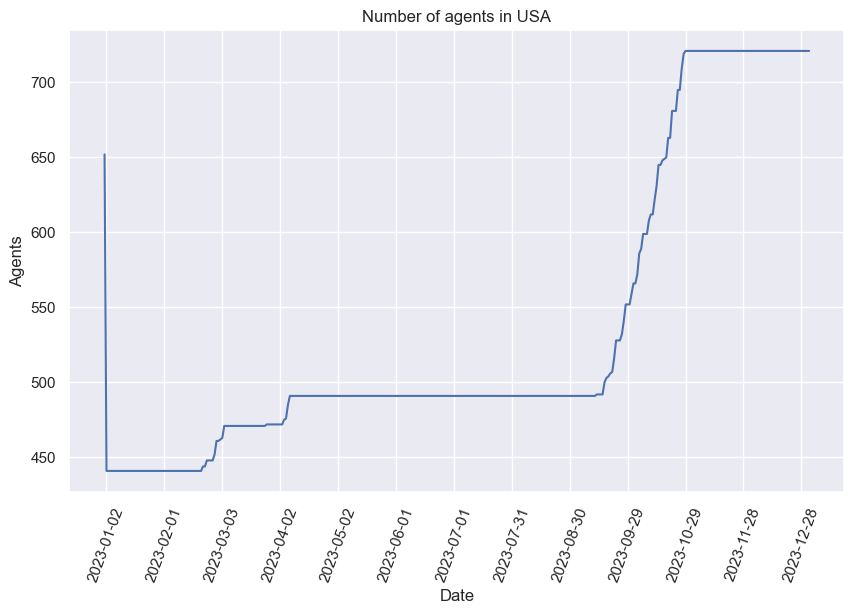

In [65]:
agent = np.array(best_agents)

dates = budget_demand.index[:agent.shape[0]]

fig, ax = plt.subplots(figsize=(10, 6))

dates_agents = pd.DataFrame({"Date": dates, "Agents": agent})

sns.set_theme()
sns.lineplot(dates_agents, x = "Date", y = "Agents")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation=70)
plt.title(f"Number of agents in USA")
plt.show()

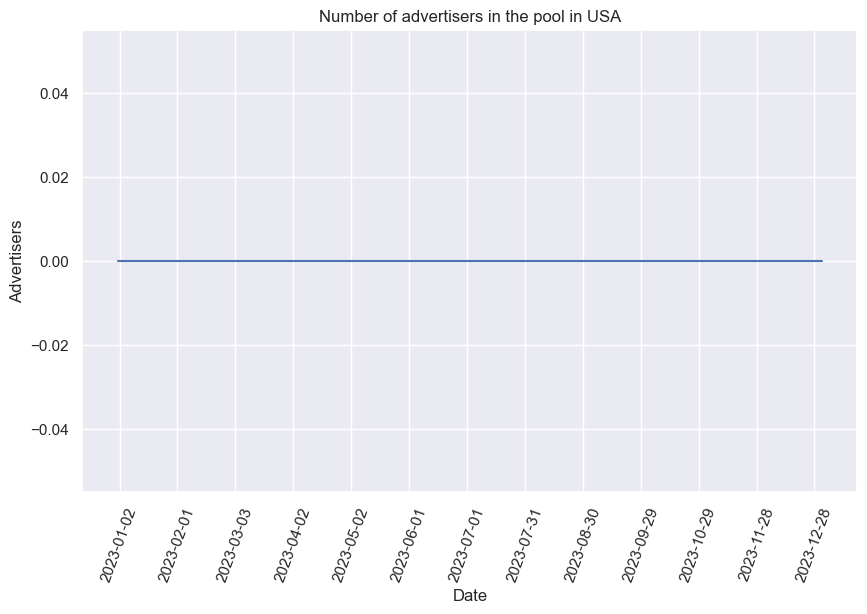

In [67]:
adv_waiting = np.array(adv_waiting)
fig, ax = plt.subplots(figsize=(10, 6))

dates_agents = pd.DataFrame({"Date": dates, "Advertisers": adv_waiting})

sns.set_theme()
sns.lineplot(dates_agents, x = "Date", y = "Advertisers")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation=70)
plt.title(f"Number of advertisers in the pool in USA")
plt.show()

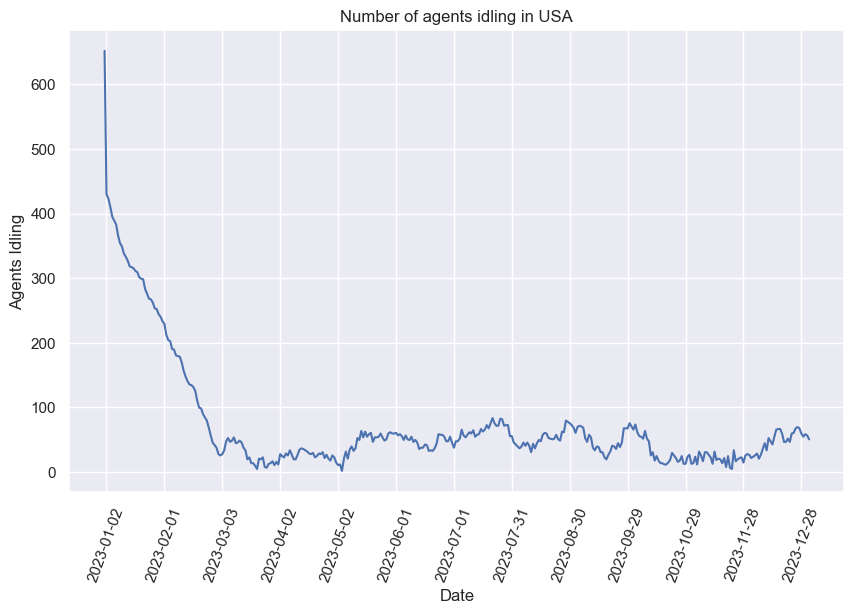

In [69]:
agents_idle = np.array(agents_idle)
fig, ax = plt.subplots(figsize=(10, 6))

dates_agents = pd.DataFrame({"Date": dates, "Agents Idling": agents_idle})

sns.set_theme()
sns.lineplot(dates_agents, x = "Date", y = "Agents Idling")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation=70)
plt.title(f"Number of agents idling in USA")
plt.show()